In [2]:
try:
    from google.colab import drive
    NOTEBOOK = 'colab'
except:
    import os    
    if list(os.walk('/kaggle/input')):            
        NOTEBOOK = 'kaggle'
    else:
        NOTEBOOK = 'home'
        
# if NOTEBOOK == 'colab':
#     drive.mount("/content/gdrive", force_remount=True)

import tensorflow as tf

# tf.debugging.set_log_device_placement(True)
# tf.config.set_visible_devices([], 'GPU') 
# tf.executing_eagerly() 

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*)])
#     except RuntimeError as e:
#         print(e)
        
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(NOTEBOOK)




home


In [3]:
if NOTEBOOK == 'colab':
    !pip install -q dm-sonnet
    !pip install -q gdown
    import gdown    
#     url = 'https://drive.google.com/uc?id=1Si-Fz-38xITBOvYOoPTn_xLtOHVwqFQO'
    url = 'https://drive.google.com/uc?id=1rMDDybiyw6bLOdVOL_SY-RoQdocRRNzl'
    output = 'GOLD_XYZ.hdf5'
    gdown.download(url, output, quiet=False)
    !df -h
    !ls -l
    !grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'
    hdf5_path = '/content/'+output
elif NOTEBOOK == 'kaggle':
    !pip install -q dm-sonnet
    import os
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            hdf5_path = os.path.join(dirname, filename)
else:          
    hdf5_path = '/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
print(hdf5_path)


/media/bognev/CE50072F50071DB9/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5


In [4]:
!grep Model: /proc/driver/nvidia/gpus/*/information | awk '{$1="";print$0}'

 GeForce GTX 650


In [5]:
# import tensorflow as tf
# tf.debugging.set_log_device_placement(True)
# import h5py
import numpy as np
import matplotlib.pyplot as plt
import random
import tqdm
import time
import h5py
import sonnet as snt
from tqdm import tqdm
import gc
import os, psutil
p = psutil.Process(os.getpid())


print("TensorFlow version: {}".format(tf.__version__))
print("    Sonnet version: {}".format(snt.__version__))
print("    Numpy  version: {}".format(np.__version__))
from tensorboard import version; print("TensorBoard version: {}".format(version.VERSION))
# tf.config.list_physical_devices('GPU')

TensorFlow version: 2.1.0
    Sonnet version: 2.0.0
    Numpy  version: 1.18.2
TensorBoard version: 2.1.0


In [6]:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops


class AlphaDropout(snt.Module):

    def __init__(self, name=None, rate=0.5, noise_shape=None, seed=None, **kwargs):
        super(AlphaDropout, self).__init__(name=name)
        self.rate = rate
        self.noise_shape = noise_shape
        self.seed = seed

    def _get_noise_shape(self, inputs):
        return self.noise_shape if self.noise_shape else inputs.shape

    @tf.function
    def __call__(self, inputs, is_training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

        def dropped_inputs(inputs=inputs, rate=self.rate, seed=self.seed):  # pylint: disable=missing-docstring
            alpha = 1.6732632423543772848170429916717
            scale = 1.0507009873554804934193349852946
            alpha_p = -alpha * scale

            kept_idx = math_ops.greater_equal(
                tf.random.uniform(noise_shape, minval=0, maxval=None, dtype=tf.dtypes.float32, seed=seed, name=None), rate)
            kept_idx = math_ops.cast(kept_idx, dtypes.float32)

            # Get affine transformation params
            a = ((1 - rate) * (1 + rate * alpha_p**2))**-0.5
            b = -a * alpha_p * rate

            # Apply mask
            x = inputs * kept_idx + alpha_p * (1 - kept_idx)

            # Do affine transformation
            return a * x + b

            if is_training==True:
                return dropped_inputs(inputs)
            else: 
                return inputs
        return inputs


  

In [7]:

class ConvMaxPool(snt.Module):
    def __init__(self, name=None):
        super(ConvMaxPool, self).__init__(name=name)
        self.conv = snt.Conv1D(output_channels=64, kernel_shape=3, stride=1, rate=1,
                               padding="SAME", with_bias=True,
                               data_format="NWC", name="conv_max_pool"
                               )
    @tf.function
    def __call__(self, inputs):
        features = self.conv(inputs)
        outputs = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="SAME", 
                                   data_format='NWC', name="pool") #64×1024
        return outputs


class CNN(snt.Module):
    def __init__(self, epsilon, name=None):
        super(CNN, self).__init__(name=name)
        self.layers = [
            ConvMaxPool(name="conv"+str(ii))
            for ii in range(6)
        ]
        self.conv_in = snt.Conv1D(output_channels=64, kernel_shape=2, stride=1, rate=1,
                       padding="SAME", with_bias=True,
                       data_format="NWC", name="conv_input"
                       )
        
        self.linear = snt.Linear(output_size=128, with_bias=True, 
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=10))
        self.linear1 = snt.Linear(output_size=128, with_bias=True,
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=13))
        self.linear2 = snt.Linear(output_size=24, with_bias=True,
                                 w_init=snt.initializers.VarianceScaling(scale = 1.0, mode='fan_in', distribution='truncated_normal', seed=14))                
        
        self.alpha = AlphaDropout(rate=0.1, noise_shape=None, seed=21)
#         self.alpha = snt.Dropout(rate=0.1, noise_shape=None, seed=21, name="DO")

    @tf.function
    def __call__(self, inputs, is_training=False):
        features = self.conv_in(inputs) #2×1024
        features = tf.nn.max_pool1d(features, ksize=2, strides=2, padding="VALID", 
                                    data_format='NWC', name="pool_input") 
#         print(features)
        for layer in self.layers:
            features = layer(features)    
        features = snt.flatten(features)

        features = self.linear(features)
        features = self.alpha(tf.nn.selu(features), is_training=is_training)
        features = self.linear1(features)
        features = self.alpha(tf.nn.selu(features), is_training=is_training)

        output = self.linear2(features)        
#         output = tf.nn.softmax(features)
        return output


In [8]:

class CNNOptimizer(snt.Module):
    def __init__(self, name, cnn, lr=1e-3, num_epochs=100, decay_lr_start_epoch=10, decay_lr=False):
        super(CNNOptimizer, self).__init__(name=name)
        self.cnn = cnn
        self.init_lr = tf.constant(lr, dtype=tf.float32)
        self.lr = tf.Variable(lr, trainable=False, name='learning rate', dtype=tf.float32)
        self.cnn_opt = snt.optimizers.Adam(learning_rate=self.lr)
        self.decay_lr_start_epoch = tf.constant(decay_lr_start_epoch, dtype=tf.float32)
        self.decay_lr = tf.constant(decay_lr, dtype=tf.bool)
        self.num_epochs = tf.constant(num_epochs, dtype=tf.float32)

    def _gen_lr_mult(self, epoch):
          # Linear decay to 0.
        decay_epoch = tf.cast(epoch - self.decay_lr_start_epoch, tf.float32)
        if decay_epoch < tf.constant(0, dtype=tf.float32):
            return tf.constant(1., dtype=tf.float32)
        num_decay_epochs = tf.cast(self.num_epochs - self.decay_lr_start_epoch, dtype=tf.float32)
        return (num_decay_epochs - decay_epoch) / num_decay_epochs        
    
    @tf.function
    def step(self, batch, labels, epoch, is_save, is_training):
        with tf.GradientTape() as tape:
            logits = self.cnn(batch, is_training=is_training)    
            loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
            loss = tf.reduce_mean(loss)
        params = self.cnn.trainable_variables
        grads = tape.gradient(loss, params)                
        lr_mult = self._gen_lr_mult(epoch)
        if self.decay_lr:
            self.lr.assign(self.init_lr * lr_mult)
        self.cnn_opt.apply(grads, params)   
        if NOTEBOOK != 'kaggle' and is_save == True:
            with writer.as_default():
                for i,g in enumerate(grads):                
                    tf.summary.histogram(name="Grad_"+params[i].name, data=g, step=step)                
                    tf.summary.histogram(name=params[i].name, data=params[i].value(), step=step)                
        return loss
    




In [9]:
class radioML:
    def __init__(self, file, batch_size, is_training=False):
        self.file = file
        self.batch_size = batch_size
        self.is_training = is_training
    
    def __call__(self):        
        N_r, N_m, N_db = 4096, 24, 13
        if NOTEBOOK == 'colab':            
            dbs = np.arange(0,32,2)     
            db_range = np.arange(0,0+len(dbs))
        else:                       
            dbs = np.arange(0,32,2)                   
            db_range = np.arange(10,10+len(dbs))
        data_idxs_train = np.array([])
        data_idxs_test = np.array([])
        for i in np.arange(N_m):            
            for j in db_range:
                ids = i*N_r*N_db+j*N_r
                idx = np.arange(ids, ids+N_r)                
                data_idxs_train = np.append(data_idxs_train, idx[np.arange(int(0.8*N_r))])
                data_idxs_test  = np.append(data_idxs_test, idx[np.arange(int(0.8*N_r)+1, N_r)])
        with h5py.File(self.file, 'r') as f:
            while True:
                if self.is_training:
                    idxs = np.random.choice(data_idxs_train, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                else:
                    idxs = np.random.choice(data_idxs_test, self.batch_size)
                    yield (f['X'][sorted(idxs)], f['Y'][sorted(idxs)])
                

def radioML_map(data_batch, data_label):
#     print(data_batch.shape)
    data_batch = tf.reshape(data_batch, [1024, 2])
    data_label = tf.reshape(data_label, [24])
#     mean = tf.math.reduce_mean(data_batch)
#     std = tf.math.reduce_std(data_batch)
#     data_batch = (data_batch - mean)/std
#     print(std, mean)
#     print(type(std))
    return (data_batch, data_label)

<dtype: 'int32'>


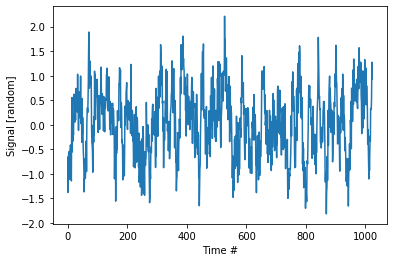

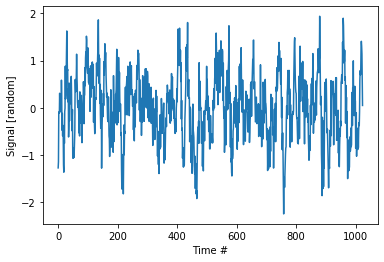

In [11]:
radio_plot = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_plot = radio_plot.take(1)
radio_plot = radio_plot.map(radioML_map)
for (batch, labels) in radio_plot:    
    print(labels.dtype)
    fig1 = plt.figure()
    plt.plot(batch[:,0])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    fig2 = plt.figure()
    plt.plot(batch[:,1])
    plt.xlabel('Time #')
    plt.ylabel('Signal [random]')
    plt.show()

In [12]:
# building tensorflow graph

# from datetime import datetime as dt
# # Clear any logs from previous runs
# !rm -rf ./logs/

# stamp = dt.now().strftime("%Y%m%d-%H%M%S")
# logdir = 'logs/func/%s' % stamp
# writer = tf.summary.create_file_writer(logdir)

# radio_model = CNN(epsilon=1e-8, name="CNN")
# radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
#                 output_types=(tf.float32, tf.float32),
#                 output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
# radio_data_test = radio_data_test.take(1)
# radio_data_test = radio_data_test.map(radioML_map)
# radio_data_test = radio_data_test.batch(1)

# for i,(batch, labels) in enumerate(radio_data_test):
#     tf.summary.trace_on(graph=True, profiler=True)    
#     preds = radio_model(batch)
#     with writer.as_default():
#         tf.summary.trace_export(
#             name='tf2_graph',
#             step=0,
#             profiler_outdir=logdir)
# %reload_ext tensorboard
# %tensorboard --logdir logs/func     

In [13]:
if NOTEBOOK != 'kaggle':
    # %load_ext tensorboard
    # import os
    from datetime import datetime as dt
    # Clear any logs from previous runs
    !rm -rf ./logs/
    log_dir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
    writer = tf.summary.create_file_writer(log_dir)


    %reload_ext tensorboard
#     %tensorboard --logdir logs/func     
    # writer.set_as_default()
    %tensorboard --logdir logs

In [17]:
if NOTEBOOK == 'colab':
    batch_size = 256
    num_batches = int(65536*2/batch_size)
elif NOTEBOOK == 'kaggle':
    batch_size = 256
    num_batches = int(65536*2/batch_size)
else:          
    batch_size = 32
    num_batches = int(4096/batch_size)



# num_batches = int(1572864/batch_size)
tf.print("Memory Usage (before import):", p.memory_info().rss/1024/1024, "MB")



num_epochs = 20

radio_model = CNN(epsilon=1e-8, name="CNN")
radio_opt = CNNOptimizer(name="Optimizer", cnn=radio_model, lr=0.001, \
                         num_epochs=num_epochs, decay_lr_start_epoch=5, decay_lr=True)

t = tqdm(range(num_batches * num_epochs),
               unit='sig', unit_scale=batch_size, position=0)


radio_data = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, True), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]

loss_history, accuracy_history, lr_history = [], [], []



test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)


# step = tf.function(radio_opt.step)
print_every = int(num_batches/2)

start_time = time.perf_counter()

# for step_num,(batch, labels) in enumerate(radio_data_train):      
for epochs in range(num_epochs):
    radio_data_train = radio_data.take(batch_size*num_batches)
    radio_data_train = radio_data_train.map(radioML_map)
    radio_data_train = radio_data_train.shuffle(buffer_size=batch_size*num_batches)
    radio_data_train = radio_data_train.batch(batch_size)            
    
    epoch = tf.constant(1+epochs, dtype=tf.float32)
    for step_num,(batch, labels) in enumerate(radio_data_train):      
        loss = radio_opt.step(batch, labels, epoch, tf.constant(step_num % num_batches == 0, dtype=tf.bool), is_training=tf.constant(True, dtype=tf.bool))

        t.update(1)    
#     if step_num % print_every == 0:                
#         tf.print('Current epoch = {}/{} (lr_mult = {:0.09f}, loss = {}) done.'.format(
#             epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy()))  
        
#     if step_num % num_batches == 0: 
    accuracy, total, correct = tf.constant(0), tf.constant(0), tf.constant(0)
    for (batch, labels) in test:            
        logits = tf.nn.softmax(radio_opt.cnn(batch, is_training=tf.constant(False, dtype=tf.bool)))
        preds = tf.argmax(logits, axis=1, output_type=tf.int32)  
        labels = tf.argmax(labels, axis=1, output_type=tf.int32)
        correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
        total += tf.shape(labels)[0]            
    accuracy = (correct / tf.cast(total, tf.int32)) * 100. 
    if NOTEBOOK != 'kaggle':
        with writer.as_default():            
            tf.summary.scalar('Accuracy', accuracy, step=epoch.numpy())               
            tf.summary.scalar('training loss', loss, step=step_num)       
            tf.summary.scalar('learning rate', radio_opt.lr, step=step_num)   
    else:
        accuracy_history.append(accuracy)
        lr_history.append(radio_opt.lr)
        loss_history.append(loss)
    t.write('Epoch = {}/{} (lr_mult = {:0.09f}, loss = {:0.02f}, accuracy = {:0.02f}, incorrect = {} done.'.format(
        epoch.numpy(), num_epochs, radio_opt.lr.numpy(), loss.numpy(), accuracy, total - correct))  
    tf.print("Memory Usage (after var-def):", p.memory_info().rss/1024/1024, "MB")
    gc.collect()
                 
print("Execution time:", time.perf_counter() - start_time)   
t.close()
   

Memory Usage (before import): 1385.3359375 MB


  0%|          | 0/81920 [00:00<?, ?sig/s]

NameError: in converted code:

    /home/bognev/anaconda3/lib/python3.7/site-packages/sonnet/src/utils.py:23 _decorate_unbound_method  *
        return decorator_fn(bound_method, self, args, kwargs)
    /home/bognev/anaconda3/lib/python3.7/site-packages/sonnet/src/base.py:291 wrap_with_name_scope_no_exception  *
        return method(*args, **kwargs)
    <ipython-input-16-5583d872907c>:35 step  *
        tf.summary.histogram(name="Grad_"+params[i].name, data=g, step=step)

    NameError: name 'step' is not defined


In [ ]:
radio_data_test = tf.data.Dataset.from_generator(radioML(hdf5_path, 1, False), 
                output_types=(tf.float32, tf.int32),
                output_shapes=(tf.TensorShape([1, 1024, 2]), tf.TensorShape([1, 24]))) #2555904, 1024, 2]
test = radio_data_test.take(1024)
test = test.map(radioML_map)
test = test.batch(batch_size)
accuracy, total, correct = tf.constant(0), tf.constant(0), tf.constant(0)
for (batch, labels) in test:
    logits = tf.nn.softmax(radio_opt.cnn(batch, is_training=False))
    preds = tf.argmax(logits, axis=1, output_type=tf.int32)  
    labels = tf.argmax(labels, axis=1, output_type=tf.int32)
    correct += tf.math.count_nonzero(tf.equal(preds, labels), dtype=tf.int32)
    total += tf.shape(labels)[0]            
accuracy = (correct / tf.cast(total, tf.int32)) * 100. 
print("Final accuracy:", accuracy)

In [ ]:

fig2 = plt.figure()
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

fig3 = plt.figure()
plt.plot(accuracy_history)
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')


fig4 = plt.figure()
plt.plot(lr_history)
plt.xlabel('Epoch #')
plt.ylabel('Learning rate')

plt.show()
loss_history

In [ ]:
print(snt.format_variables(radio_model.variables))